# Neeraj Joshi
# Experiment - Implementation of Autoencoder

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [2]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [3]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [4]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
dataset = MNIST('./data', download=True,transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [8]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:0.2107
epoch [2/100], loss:0.1717
epoch [3/100], loss:0.1764
epoch [4/100], loss:0.1555
epoch [5/100], loss:0.1646
epoch [6/100], loss:0.1646
epoch [7/100], loss:0.1480
epoch [8/100], loss:0.1563
epoch [9/100], loss:0.1435
epoch [10/100], loss:0.1435
epoch [11/100], loss:0.1363
epoch [12/100], loss:0.1534
epoch [13/100], loss:0.1561
epoch [14/100], loss:0.1343
epoch [15/100], loss:0.1507
epoch [16/100], loss:0.1487
epoch [17/100], loss:0.1406
epoch [18/100], loss:0.1393
epoch [19/100], loss:0.1381
epoch [20/100], loss:0.1347
epoch [21/100], loss:0.1451
epoch [22/100], loss:0.1306
epoch [23/100], loss:0.1394
epoch [24/100], loss:0.1268
epoch [25/100], loss:0.1400
epoch [26/100], loss:0.1357
epoch [27/100], loss:0.1376
epoch [28/100], loss:0.1279
epoch [29/100], loss:0.1254
epoch [30/100], loss:0.1199
epoch [31/100], loss:0.1479
epoch [32/100], loss:0.1228
epoch [33/100], loss:0.1310
epoch [34/100], loss:0.1306
epoch [35/100], loss:0.1360
epoch [36/100], loss:0.1391
e

## Conv Autoencoder

In [9]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

In [10]:
class Conv_autoencoder(nn.Module):
    def __init__(self):
        super(Conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
model = Conv_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [ ]:
from PIL import Image

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
       
        save_image(pic, './dc_img/image_{}.png'.format(epoch))


torch.save(model.state_dict(), './conv_autoencoder.pth')

epoch [1/100], loss:225.5768
epoch [2/100], loss:129.7889
epoch [3/100], loss:87.5596
epoch [4/100], loss:74.1103
epoch [5/100], loss:68.6574
epoch [6/100], loss:65.0454
epoch [7/100], loss:62.4504
epoch [8/100], loss:60.4204
epoch [9/100], loss:58.8078
epoch [10/100], loss:57.4415
epoch [11/100], loss:56.1750
epoch [12/100], loss:55.1178
epoch [13/100], loss:54.2471
epoch [14/100], loss:53.5043
epoch [15/100], loss:52.8370
epoch [16/100], loss:52.2537
epoch [17/100], loss:51.7035
epoch [18/100], loss:51.2388
epoch [19/100], loss:50.8078
epoch [20/100], loss:50.4021
epoch [21/100], loss:50.0138
epoch [22/100], loss:49.6216
epoch [23/100], loss:49.2361
epoch [24/100], loss:48.9123
epoch [25/100], loss:48.5640
epoch [26/100], loss:48.2795
epoch [27/100], loss:47.9361
epoch [28/100], loss:47.6227
epoch [29/100], loss:47.3409
epoch [30/100], loss:47.0674
epoch [31/100], loss:46.8433
epoch [32/100], loss:46.6265
epoch [33/100], loss:46.4068
epoch [34/100], loss:46.2071
epoch [35/100], loss:

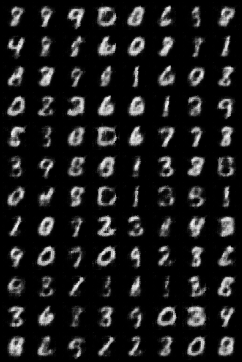

In [ ]:
img